# Metrics, Loss, générateur et data augmentation

## Fonction de scoring

Future Vision Transport est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

early stopping and check point

modèle simple non pré-entraîné comme « Unet mini » et un modèle pré-entraîné comme « VGG16 Unet » (encoder = VGG16 pré-entraîné), CF « Ressources »
L’étudiant pourra tester différents types de loss, comme le Dice_loss, le total_loss, ou balanced_cross_entropy
Les mesures principales dans ce contexte sont l’IoU (Jaccard) et le Dice_coeff

In [2]:
from tensorflow.keras.layers import Conv2D, Input,Dropout, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, concatenate, UpSampling2D
from keras_segmentation.models.model_utils import get_segmentation_model
from tensorflow.keras.models import Model

import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from keras import backend as K
from functions import *
from functions import show_2img
from class_ import MY_Generator, MY_Generator_


import imgaug.augmenters as iaa
from cv2 import imread, resize
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import imgaug as ia
import numpy as np
import random
import os
import cv2


import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from class_ import MY_Generator
from keras import backend as K
import pandas as pd
from functions import show_2img


df = pd.read_csv('data.csv')
callback = [EarlyStopping(monitor='val_loss', patience=6)]
    
list_dire = os.listdir('../label/')
name = [path.split('gtFine_labelIds.png')[0] for path in list_dire]

X = np.array([cv2.imread(f'data/{name[u]}leftImg8bit.png') for u in range(0,10)])
y_true = np.array([cv2.resize(cv2.imread(f'../label/{name[u]}gtFine_labelIds.png', 0), 
                              (1024, 512)) for u in range(0,10)])


### Tversky loss
def balanced_cross_entropy(beta):
    def loss(y_true, y_pred):
        weight_a = beta * tf.cast(y_true, tf.float32)
        weight_b = (1 - beta) * tf.cast(1 - y_true, tf.float32)

        o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
        return tf.reduce_mean(o)
    return loss

### Dice Loss 
def tversky_loss(beta):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.math.sigmoid(y_pred)
        numerator = y_true * y_pred
        denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

        return 1 - tf.reduce_sum(numerator) / tf.reduce_sum(denominator)

    return loss

### Dice Loss
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

### Dice Metrics
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

### Jackar Metrics
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


# Modèle VGG_Unet

<img src='https://divamgupta.com/assets/images/posts/imgseg/image12.png?style=centerme'>

In [3]:
%%time
# Construction du modèle à l'aide de class
from keras_segmentation.models.unet import vgg_unet
class My_vgg_unet(Model):
    def __init__(self, input_shape_):
        self.input_shape_ = input_shape_
    
    def build_model(self):
        def predict_class(X, input_shape_):
            X = self.predict_generator(X)
            y_pred = []
            for x in X :
                p = []
                for u in x:
                    for i in u:
                        p.append(i.argmax())
                y_pred.append(np.array(p).reshape((input_shape_[1], input_shape_[0], 8)))
            return y_pred
        
        
        model_unet = vgg_unet(n_classes = 8, 
                              input_height=self.input_shape_[0], 
                              input_width =self.input_shape_[1])

        self = model_unet
        self.predict_class = predict_class
        
        return self

CPU times: user 2.32 ms, sys: 2.57 ms, total: 4.89 ms
Wall time: 4.74 ms


## Entrainement du modèle de référence

In [4]:
model_vgg_unet = My_vgg_unet((1024,2048,3)).build_model()
model_vgg_unet.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[iou_coef])

model_vgg_unet_history = model_vgg_unet.train(n_classes=8,
    train_images =  "./data//",
    train_annotations = "../label copie/",
    checkpoints_path = "vgg_unet_1" , epochs=20
)

Metal device set to: Apple M1 Max


2022-03-08 00:39:01.531119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 00:39:01.531539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Verifying training dataset


100%|███████████████████████████████████████| 3475/3475 [03:09<00:00, 18.35it/s]
/Users/kevinduranty/miniforge3/envs/p8/lib/python3.8/site-packages/keras_segmentation/train.py:156: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, steps_per_epoch,


Dataset verified! 
Epoch 1/20


2022-03-08 00:42:11.631731: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-08 00:42:12.159341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


512/512 [==============================] - 1504s 3s/step - loss: 2.6025 - accuracy: 0.2237
Epoch 2/20
512/512 [==============================] - 1505s 3s/step - loss: 2.0560 - accuracy: 0.3772
Epoch 3/20
512/512 [==============================] - 1541s 3s/step - loss: 1.8128 - accuracy: 0.4561
Epoch 4/20
512/512 [==============================] - 1558s 3s/step - loss: 1.7047 - accuracy: 0.5025
Epoch 5/20
512/512 [==============================] - 1560s 3s/step - loss: 1.6395 - accuracy: 0.5160
Epoch 6/20
512/512 [==============================] - 1557s 3s/step - loss: 1.5710 - accuracy: 0.5339
Epoch 7/20
512/512 [==============================] - 1515s 3s/step - loss: 1.5572 - accuracy: 0.5341
Epoch 8/20
512/512 [==============================] - 1497s 3s/step - loss: 1.5253 - accuracy: 0.5433
Epoch 9/20
512/512 [==============================] - 1497s 3s/step - loss: 1.4900 - accuracy: 0.5532
Epoch 10/20
512/512 [==============================] - 1496s 3s/step - loss: 1.4915 - accurac

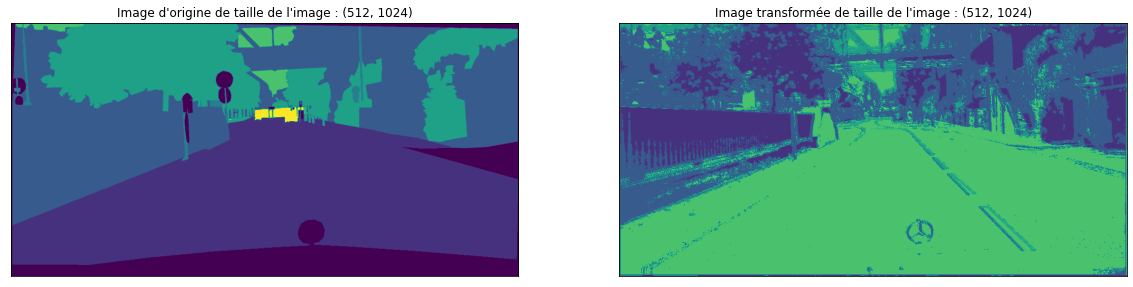

INFO:tensorflow:Assets written to: model_vgg_unet/assets


In [37]:
y_pred = np.array([[i.argmax() for i in u] for u in model_vgg_unet.predict(X[:1])[0].reshape((512, 1024, 8))])
show_2img(y_true[0],y_pred)
model_vgg_unet.save('model_vgg_unet')

## 

In [35]:
%%time
model_vgg_unet2 = My_vgg_unet((1024,2048,3)).build_model()

model_vgg_unet_history2 = model_vgg_unet2.train(n_classes=8, 
                                                train_images =  "./data/",
                                                train_annotations = "../label copie/",
                                                checkpoints_path = "vgg_unet_1" , epochs=1,
                                              optimizer_name='adam',
                                              )

Verifying training dataset


  7%|██▉                                     | 253/3475 [00:13<02:56, 18.21it/s]


KeyboardInterrupt: 

In [ ]:
show_2img(y_true[0],model_vgg_unet.predict_class(X_, (1024, 512))[0])

## 

In [ ]:
model_vgg_unet = My_vgg_unet((1024,2048,3)).build_model()
model_vgg_unet.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[iou_coef])

model_vgg_unet_history = model_vgg_unet.train(n_classes=8,
                                                train_images =  "./data//",
                                                train_annotations = "../label copie/",
                                                checkpoints_path = "vgg_unet_1" , epochs=1,
                                              )

plt_learningcurve(model_vgg_unet_history, 'iou_coef')
show_2img(y_true[0],model_vgg_unet.predict_class(X_, (1024, 512))[0])

# Entrainement VGG16


<img src='https://divamgupta.com/assets/images/posts/imgseg/image4.png?style=centerme'>

<timed exec>:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
2022-03-08 09:50:49.224326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


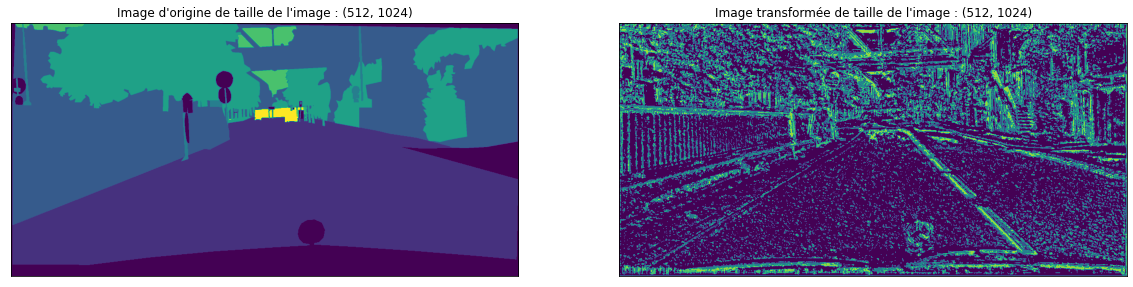

CPU times: user 779 ms, sys: 460 ms, total: 1.24 s
Wall time: 976 ms


In [38]:
%%time
# Construction du modèle

from tensorflow.keras.applications.vgg16 import VGG16

class My_VGG_(Model):
    def __init__(self, input_shape_):
        self.input_shape_ = input_shape_
        self.model = None
        
    def build_model(self):
        def predict_class(X, input_shape_):
            X = self.predict_generator(X)
            y_pred = []
            for x in X :
                p = []
                for u in x:
                    for i in u:
                        p.append(i.argmax())
                y_pred.append(np.array(p).reshape((input_shape_[1], input_shape_[0])))
            return y_pred
        
        
        model_vgg = VGG16(include_top=False, input_shape=self.input_shape_,weights="imagenet")

        #for layer in model_vgg.layers:
                   # layer.trainable = False

        # Parie Décodeur Custom
        # 1
        conv6 = Conv2D(128, (3, 3), activation='relu', 
                       padding='same')(model_vgg.get_layer('block5_pool').output)
        conv6 = Dropout(0.2)(conv6)
        conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
        up1 = concatenate([UpSampling2D((2, 2))(conv6), model_vgg.get_layer('block5_conv3').output], axis=-1)


        # 2eme Couche connectée
        conv7 = Conv2D(128, (3, 3), activation='relu', 
                       padding='same')(up1)
        conv7 = Dropout(0.2)(conv7)
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
        up2 = concatenate([UpSampling2D((2, 2))(conv7), model_vgg.get_layer('block4_conv2').output], axis=-1)

        # 3eme Couche connectée
        conv8 = Conv2D(128, (3, 3), activation='relu', 
                       padding='same')(up2)
        conv8 = Dropout(0.2)(conv8)
        conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
        up3 = concatenate([UpSampling2D((2, 2))(conv8), model_vgg.get_layer('block3_conv2').output], axis=-1)


        # 4eme Couche connectée
        conv9 = Conv2D(128, (3, 3), activation='relu', 
                       padding='same')(up3)
        conv9 = Dropout(0.2)(conv9)
        conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

        up4 = concatenate([UpSampling2D((2, 2))(conv9), model_vgg.get_layer('block2_conv2').output], axis=-1)


        # 4eme Couche connectée
        conv10 = Conv2D(128, (3, 3), activation='relu', 
                       padding='same')(up4)
        conv10 = Dropout(0.2)(conv10)
        conv10 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv10)

        up5 = concatenate([UpSampling2D((2, 2))(conv10), 
                           model_vgg.get_layer('block1_conv2').output], axis=-1)

        # Connexion entre toutes les couches
        out = Conv2D(8, (1, 1) , padding='same', activation='softmax')(conv10)
        self = Model(model_vgg.input ,  out)
        
        self.predict_class = predict_class
        return self

# Observation du modèle avant entrainement 
model_vgg16 = My_VGG_((1024,2048,3)).build_model()
show_2img(y_true[0],model_vgg16.predict_class(X[:1], (1024, 512))[0])

## 

Epoch 1/50


<timed exec>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
2022-03-08 10:07:30.615436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.1878 - iou_coef: 0.5200

2022-03-08 10:10:17.202975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 179s 4s/step - loss: 0.1878 - iou_coef: 0.5200 - val_loss: 0.1557 - val_iou_coef: 0.5499
Epoch 2/50
50/50 [==============================] - 177s 4s/step - loss: 0.1578 - iou_coef: 0.5845 - val_loss: 0.1398 - val_iou_coef: 0.5981
Epoch 3/50
50/50 [==============================] - 178s 4s/step - loss: 0.1420 - iou_coef: 0.6156 - val_loss: 0.1546 - val_iou_coef: 0.5848
Epoch 4/50
50/50 [==============================] - 177s 4s/step - loss: 0.1393 - iou_coef: 0.6273 - val_loss: 0.1363 - val_iou_coef: 0.6329
Epoch 5/50
50/50 [==============================] - 177s 4s/step - loss: 0.1305 - iou_coef: 0.6501 - val_loss: 0.1378 - val_iou_coef: 0.6162
Epoch 6/50
50/50 [==============================] - 177s 4s/step - loss: 0.1259 - iou_coef: 0.6582 - val_loss: 0.1278 - val_iou_coef: 0.6252
Epoch 7/50
50/50 [==============================] - 177s 4s/step - loss: 0.1167 - iou_coef: 0.6803 - val_loss: 0.1039 - val_iou_coef: 0.6930
Epoch 8/50
50/50 [======

<timed exec>:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
2022-03-08 11:30:30.168655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


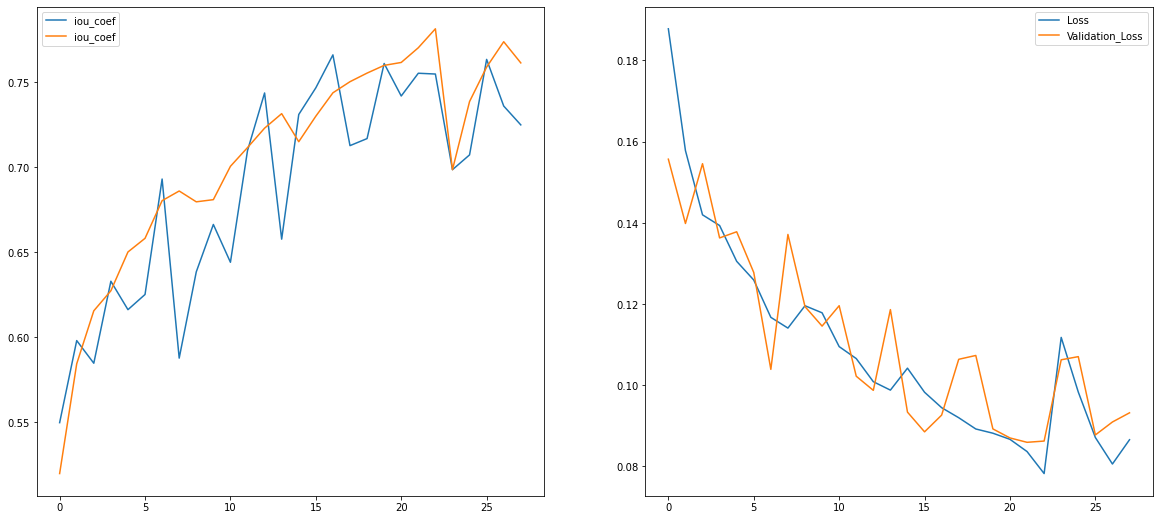

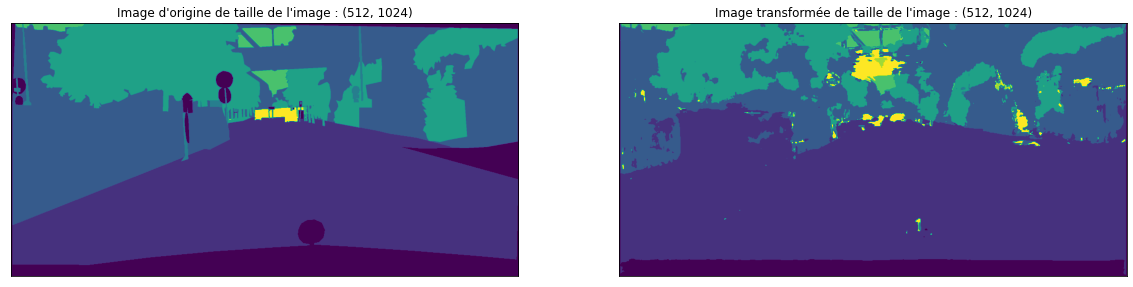

CPU times: user 9min 34s, sys: 39min 36s, total: 49min 11s
Wall time: 1h 23min 1s


In [42]:
%%time
my_training_batch_generator = MY_Generator_(df.id[:100], 2, canal=3)
my_validation_batch_generator = MY_Generator_(df.id[100:140], 2, canal=3)

model_vgg16.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[iou_coef])
callback = [EarlyStopping(monitor='val_loss', patience=15)]

model_history0 = model_vgg16.fit_generator(generator=my_training_batch_generator,
                    validation_data=my_validation_batch_generator,
                                           callbacks = callback,
                    epochs=100,
                    verbose=1,
                    workers=2,
                    )

plt_learningcurve(model_history0, 'iou_coef')
show_2img(y_true[0],model_vgg16.predict_class(X[:1], (1024, 512))[0])

## 

In [ ]:
%%time
model_vgg16_ = My_VGG_((1024,2048,3)).build_model()

model_vgg16_.compile(optimizer='Adagrad', loss=['binary_crossentropy'], metrics=[dice_coef])


model_history2 = model_vgg16_.fit_generator(generator=my_training_batch_generator,
                    validation_data=my_validation_batch_generator,
                    epochs=15,
                    verbose=1,
                    workers=2
                    )

plt_learningcurve(model_history2, 'iou_coef')
show_2img(y_true[0],model_vgg16_.predict_class(X[:1], (1024, 512))[0])

## 

Epoch 1/100


/var/folders/pd/d9xkkvws5r5f_x34lthx34ph0000gn/T/ipykernel_39748/875914478.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history3 = model_vgg16_3.fit_generator(generator=my_training_batch_generator,
2022-03-08 11:39:09.022504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 5.1731 - dice_coef: 0.3626

2022-03-08 11:41:57.801619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 182s 4s/step - loss: 5.1731 - dice_coef: 0.3626 - val_loss: 0.9531 - val_dice_coef: 0.4756
Epoch 2/100
50/50 [==============================] - 181s 4s/step - loss: 0.9667 - dice_coef: 0.4004 - val_loss: 0.5589 - val_dice_coef: 0.4829
Epoch 3/100
50/50 [==============================] - 181s 4s/step - loss: 0.6021 - dice_coef: 0.4165 - val_loss: 0.3969 - val_dice_coef: 0.4576
Epoch 4/100
50/50 [==============================] - 181s 4s/step - loss: 0.4329 - dice_coef: 0.4207 - val_loss: 0.3294 - val_dice_coef: 0.4354
Epoch 5/100
50/50 [==============================] - 181s 4s/step - loss: 0.3610 - dice_coef: 0.4310 - val_loss: 0.3048 - val_dice_coef: 0.4442
Epoch 6/100
50/50 [==============================] - 181s 4s/step - loss: 0.3284 - dice_coef: 0.4416 - val_loss: 0.2983 - val_dice_coef: 0.4516
Epoch 7/100
50/50 [==============================] - 181s 4s/step - loss: 0.3142 - dice_coef: 0.4458 - val_loss: 0.2862 - val_dice_coef: 0.4612
Epoc

<timed exec>:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
2022-03-08 16:39:51.766682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


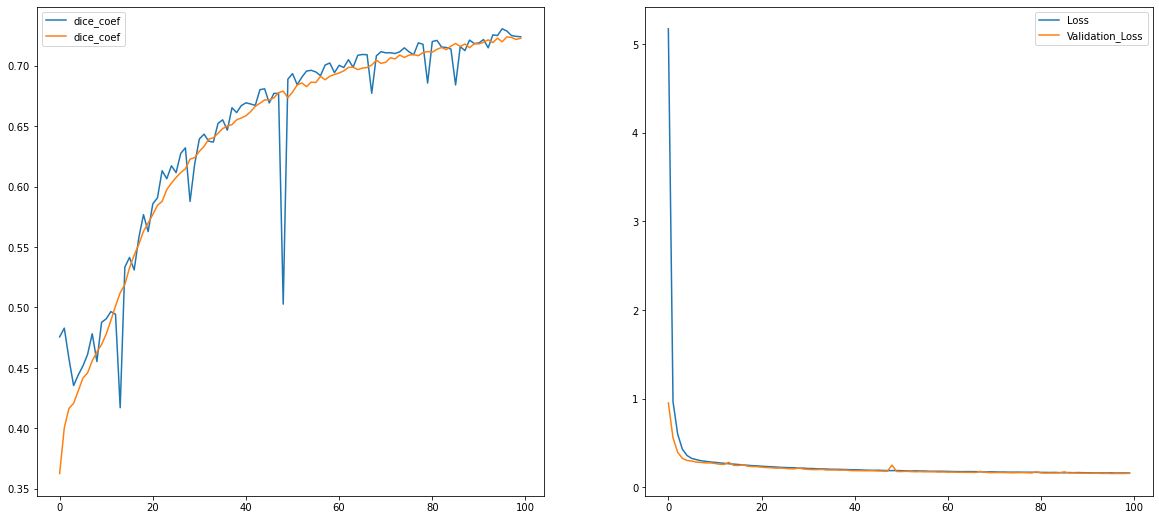

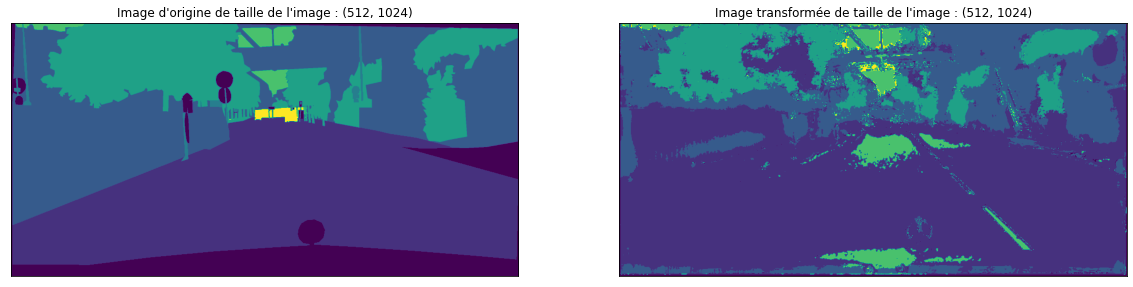

In [44]:
model_vgg16_3 = My_VGG_((1024,2048,3)).build_model()
model_vgg16_3.compile(optimizer='Adagrad', loss=['binary_crossentropy'], metrics=[dice_coef])

callback = [EarlyStopping(monitor='val_loss', patience=20)]

model_history3 = model_vgg16_3.fit_generator(generator=my_training_batch_generator,
                    validation_data=my_validation_batch_generator,
                    epochs=100,callbacks=callback,
                    verbose=1,
                    workers=2
                    )

plt_learningcurve(model_history3, 'dice_coef')
show_2img(y_true[0],model_vgg16_3.predict_class(X[:1], (1024, 512))[0])

In [61]:
model_vgg16_3.save('model_vgg16')
model_vgg16_3.save_weights('model_vgg16')

INFO:tensorflow:Assets written to: model_vgg16/assets


# Construction d'un modèle de convolution


[A compléter]

<img src='https://divamgupta.com/assets/images/posts/imgseg/image6.png?style=centerme'>

2022-03-09 17:43:53.215628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 17:43:53.215783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
<timed exec>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
2022-03-09 17:43:53.346743: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-09 17:43:53.392911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Max


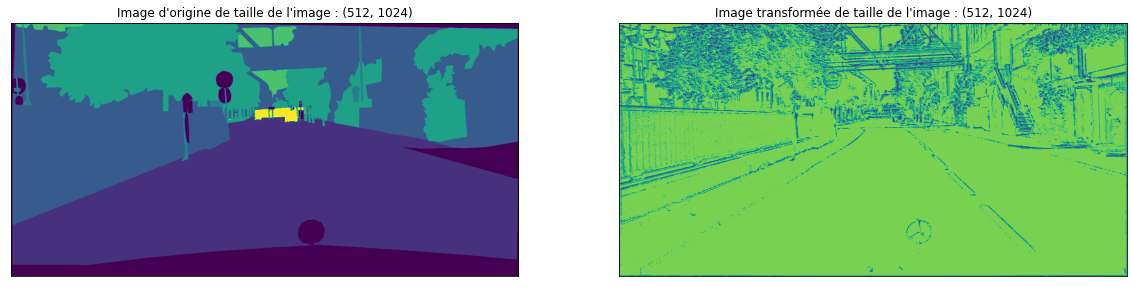

CPU times: user 1.1 s, sys: 619 ms, total: 1.72 s
Wall time: 1.33 s


In [4]:
%%time
class My_Model_(Model):
    def __init__(self, input_shape_):
        self.input_shape_ = input_shape_
        self.model = None
        
    def build_model(self):
        def predict_class(X, input_shape_):
            X = self.predict_generator(X)
            y_pred = []
            for x in X :
                p = []
                for u in x:
                    for i in u:
                        p.append(i.argmax())
                y_pred.append(np.array(p).reshape((input_shape_[1], input_shape_[0])))
            return y_pred
        
        
        img_input = Input(shape=self.input_shape_)

        
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
        conv1 = Dropout(0.2)(conv1)
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D((2, 2))(conv1)

        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = Dropout(0.2)(conv2)
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D((2, 2))(conv2)


        ## Décodeur
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = Dropout(0.2)(conv3)
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

        up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
        conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
        conv4 = Dropout(0.2)(conv4)
        conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

        up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
        conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
        conv5 = Dropout(0.2)(conv5)
        conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

        out = Conv2D(8, (1, 1) , padding='same', activation='softmax')(conv5)

        model = Model(img_input ,  out)
        self = model
        self.predict_class = predict_class
        return self
    
# Observation du modèle avant entrainement 
model_cnn = My_Model_((1024,2048,3)).build_model()
show_2img(y_true[0],model_cnn.predict_class(X[:1], (2048, 1024))[0])

## 

Epoch 1/100


<timed exec>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
2022-03-09 17:43:59.204762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5672 - iou_coef: 0.1368

2022-03-09 17:44:40.453444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 44s 859ms/step - loss: 0.5672 - iou_coef: 0.1368 - val_loss: 0.3653 - val_iou_coef: 0.1305
Epoch 2/100
50/50 [==============================] - 43s 856ms/step - loss: 0.3173 - iou_coef: 0.2014 - val_loss: 0.3705 - val_iou_coef: 0.1401
Epoch 3/100
50/50 [==============================] - 43s 858ms/step - loss: 0.2747 - iou_coef: 0.2869 - val_loss: 0.2584 - val_iou_coef: 0.3224
Epoch 4/100
50/50 [==============================] - 43s 859ms/step - loss: 0.2492 - iou_coef: 0.3470 - val_loss: 0.2745 - val_iou_coef: 0.2463
Epoch 5/100
50/50 [==============================] - 43s 858ms/step - loss: 0.2217 - iou_coef: 0.4035 - val_loss: 0.2415 - val_iou_coef: 0.3306
Epoch 6/100
50/50 [==============================] - 43s 859ms/step - loss: 0.2127 - iou_coef: 0.4296 - val_loss: 0.2105 - val_iou_coef: 0.3853
Epoch 7/100
50/50 [==============================] - 43s 857ms/step - loss: 0.1946 - iou_coef: 0.4687 - val_loss: 0.1946 - val_iou_coef: 0.4594
Epoc

<timed exec>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
2022-03-09 18:17:42.397354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


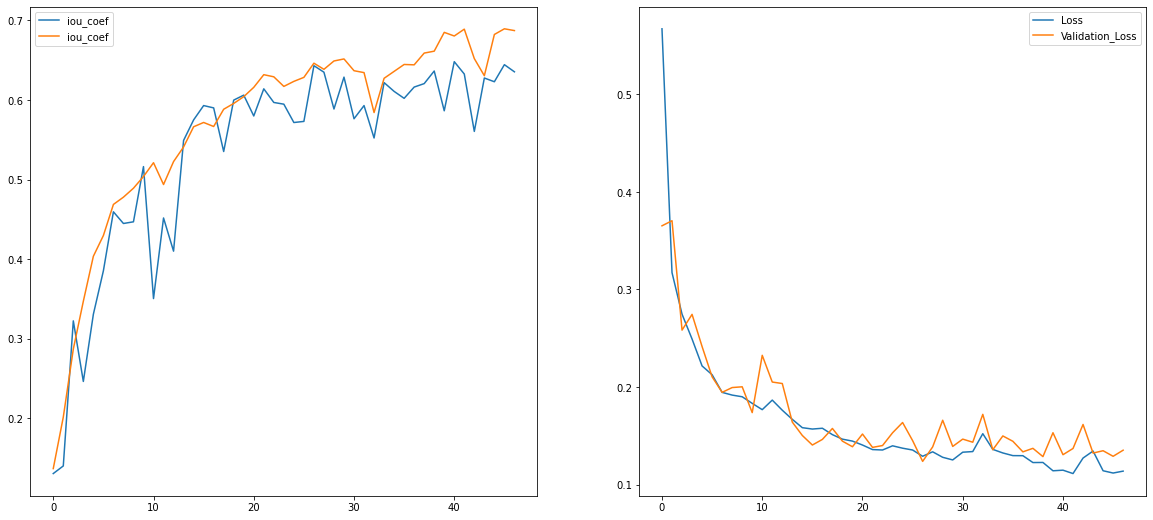

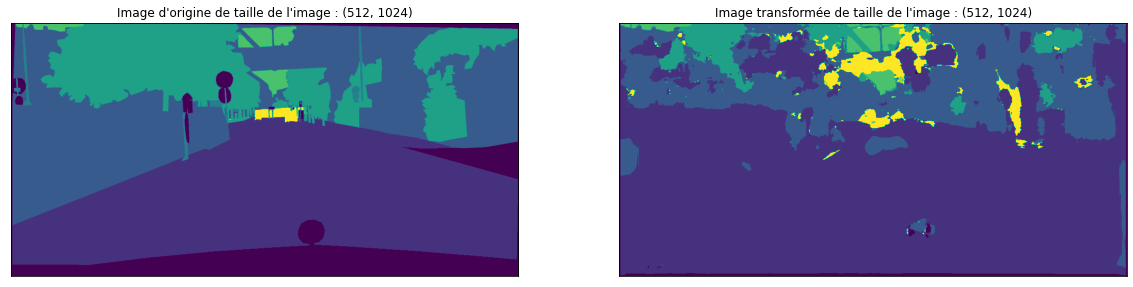

CPU times: user 11min 18s, sys: 16min 3s, total: 27min 21s
Wall time: 33min 44s


In [5]:
%%time
model_cnn = My_Model_((512,1024,3)).build_model()

my_training_batch_generator = MY_Generator(df.id[:100], 2, canal=3, red_shape=(1024, 512))
my_validation_batch_generator = MY_Generator(df.id[100:140], 2, canal=3, red_shape=(1024, 512))
callback = [EarlyStopping(monitor='val_loss', patience=20)]

model_cnn.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[iou_coef])
model_history = model_cnn.fit_generator(generator=my_training_batch_generator,
                    validation_data=my_validation_batch_generator,
                    epochs=100,
                    verbose=1,
                    workers=2,
                    callbacks = callback
                    )
plt_learningcurve(model_history, 'iou_coef')
show_2img(y_true[0],model_cnn.predict_class(np.array([resize(X[0], (1024, 512))]), (1024, 512))[0])

In [65]:
model_cnn.save('model_cnn')

INFO:tensorflow:Assets written to: model_cnn/assets


## 

Epoch 1/100


<timed exec>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
2022-03-09 18:17:43.458695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.7902 - dice_coef: 0.2110

2022-03-09 18:18:24.668837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 44s 860ms/step - loss: 0.7902 - dice_coef: 0.2110 - val_loss: 0.7854 - val_dice_coef: 0.2654
Epoch 2/100
50/50 [==============================] - 43s 850ms/step - loss: 0.7867 - dice_coef: 0.2508 - val_loss: 0.7854 - val_dice_coef: 0.2655
Epoch 3/100
50/50 [==============================] - 43s 849ms/step - loss: 0.7865 - dice_coef: 0.2528 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 4/100
50/50 [==============================] - 43s 849ms/step - loss: 0.7864 - dice_coef: 0.2535 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 5/100
50/50 [==============================] - 43s 849ms/step - loss: 0.7864 - dice_coef: 0.2538 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 6/100
50/50 [==============================] - 43s 851ms/step - loss: 0.7864 - dice_coef: 0.2540 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 7/100
50/50 [==============================] - 43s 849ms/step - loss: 0.7864 - dice_coef: 0.2541 - val_loss: 0.7854 - val_dice_coe

Epoch 57/100
50/50 [==============================] - 43s 850ms/step - loss: 0.7863 - dice_coef: 0.2546 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 58/100
50/50 [==============================] - 43s 850ms/step - loss: 0.7863 - dice_coef: 0.2546 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 59/100
50/50 [==============================] - 43s 851ms/step - loss: 0.7863 - dice_coef: 0.2546 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 60/100
50/50 [==============================] - 43s 851ms/step - loss: 0.7863 - dice_coef: 0.2546 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 61/100
50/50 [==============================] - 43s 850ms/step - loss: 0.7863 - dice_coef: 0.2546 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 62/100
50/50 [==============================] - 43s 851ms/step - loss: 0.7863 - dice_coef: 0.2546 - val_loss: 0.7854 - val_dice_coef: 0.2656
Epoch 63/100
50/50 [==============================] - 43s 849ms/step - loss: 0.7863 - dice_coef: 0.2546 - val_loss: 0.

<timed exec>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
2022-03-09 19:07:28.766435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


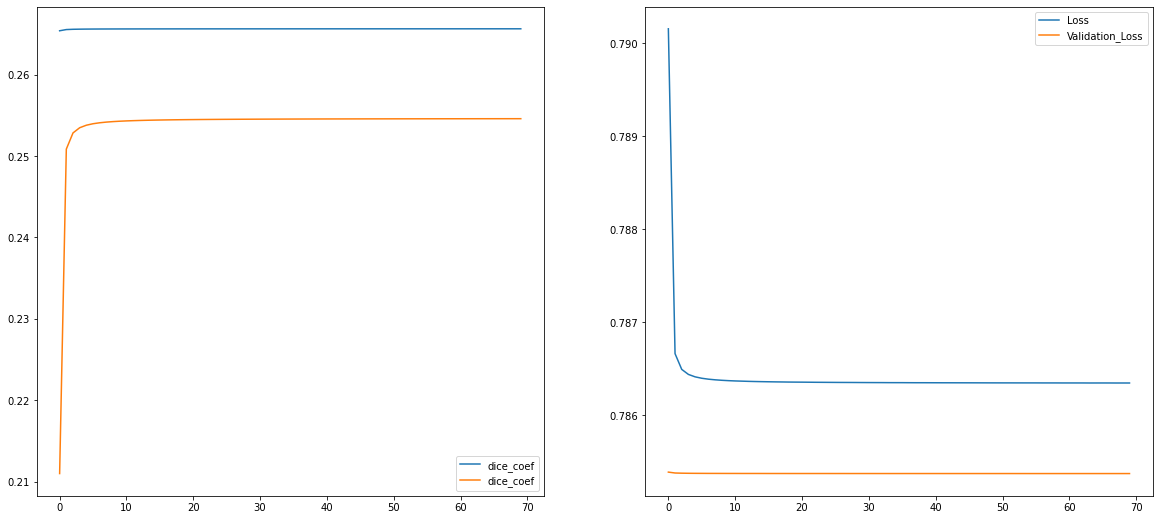

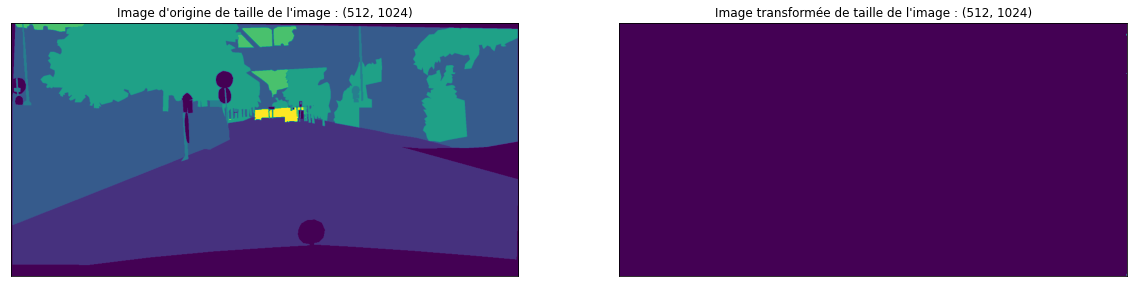

CPU times: user 16min 29s, sys: 23min 27s, total: 39min 56s
Wall time: 49min 46s


In [6]:
%%time
callback = [EarlyStopping(monitor='val_loss', patience=15)]

model_cnn2 = My_Model_((512,1024,3)).build_model()
model_cnn2.compile(optimizer='SGD', loss=[dice_loss], metrics=[dice_coef])
model_history2 = model_cnn2.fit_generator(generator=my_training_batch_generator,
                    validation_data=my_validation_batch_generator,
                    epochs=100,
                    verbose=1,
                    workers=2,
                    callbacks = callback
                    )

plt_learningcurve(model_history2, 'dice_coef')
show_2img(y_true[0],model_cnn2.predict_class(np.array([resize(X[0], (1024, 512))]), (1024, 512))[0])

## 

Epoch 1/100


<timed exec>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
2022-03-09 19:07:29.637047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5672 - dice_coef: 0.1976

2022-03-09 19:08:10.682033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 44s 862ms/step - loss: 0.5672 - dice_coef: 0.1976 - val_loss: 0.3554 - val_dice_coef: 0.2532
Epoch 2/100
50/50 [==============================] - 43s 857ms/step - loss: 0.3613 - dice_coef: 0.2793 - val_loss: 0.3397 - val_dice_coef: 0.2741
Epoch 3/100
50/50 [==============================] - 43s 856ms/step - loss: 0.3484 - dice_coef: 0.2918 - val_loss: 0.3240 - val_dice_coef: 0.3140
Epoch 4/100
50/50 [==============================] - 43s 859ms/step - loss: 0.3407 - dice_coef: 0.3005 - val_loss: 0.3501 - val_dice_coef: 0.2478
Epoch 5/100
50/50 [==============================] - 43s 859ms/step - loss: 0.3328 - dice_coef: 0.3077 - val_loss: 0.3158 - val_dice_coef: 0.3576
Epoch 6/100
50/50 [==============================] - 43s 858ms/step - loss: 0.3311 - dice_coef: 0.3120 - val_loss: 0.3059 - val_dice_coef: 0.3280
Epoch 7/100
50/50 [==============================] - 43s 860ms/step - loss: 0.3179 - dice_coef: 0.3273 - val_loss: 0.3064 - val_dice_coe

Epoch 57/100
50/50 [==============================] - 43s 861ms/step - loss: 0.2262 - dice_coef: 0.5625 - val_loss: 0.2292 - val_dice_coef: 0.5624
Epoch 58/100
50/50 [==============================] - 43s 861ms/step - loss: 0.2223 - dice_coef: 0.5704 - val_loss: 0.3662 - val_dice_coef: 0.4569
Epoch 59/100
50/50 [==============================] - 43s 859ms/step - loss: 0.2315 - dice_coef: 0.5492 - val_loss: 0.3629 - val_dice_coef: 0.2537
Epoch 60/100
50/50 [==============================] - 43s 858ms/step - loss: 0.2232 - dice_coef: 0.5626 - val_loss: 0.2799 - val_dice_coef: 0.5293
Epoch 61/100
50/50 [==============================] - 43s 858ms/step - loss: 0.2181 - dice_coef: 0.5784 - val_loss: 0.2246 - val_dice_coef: 0.5678
Epoch 62/100
50/50 [==============================] - 43s 856ms/step - loss: 0.2161 - dice_coef: 0.5818 - val_loss: 0.3090 - val_dice_coef: 0.3844
Epoch 63/100
50/50 [==============================] - 43s 860ms/step - loss: 0.2301 - dice_coef: 0.5533 - val_loss: 0.

<timed exec>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
2022-03-09 20:19:06.431632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


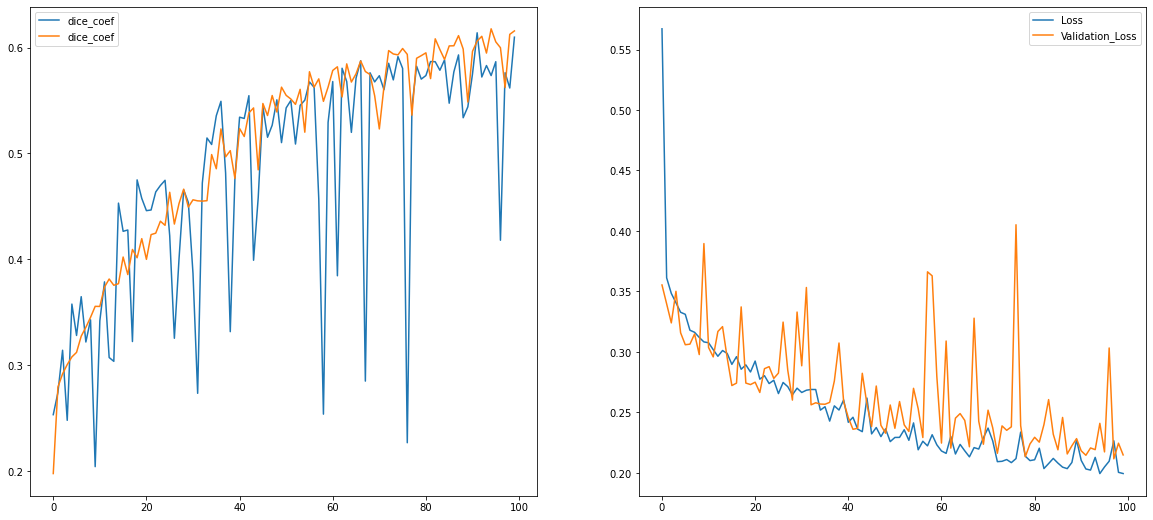

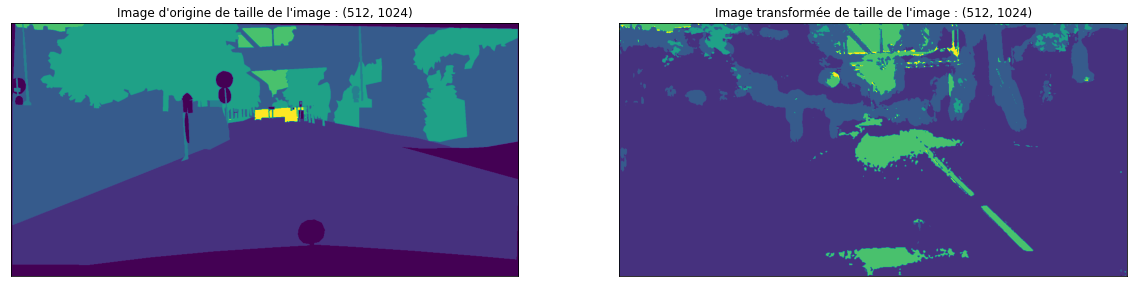

CPU times: user 24min 1s, sys: 34min 48s, total: 58min 49s
Wall time: 1h 11min 37s


In [7]:
%%time
callback = [EarlyStopping(monitor='val_loss', patience=25)]

model_cnn3 = My_Model_((512,1024,3)).build_model()
model_cnn3.compile(optimizer='SGD', loss=['binary_crossentropy'], metrics=[dice_coef])
model_history3 = model_cnn3.fit_generator(generator=my_training_batch_generator,
                    validation_data=my_validation_batch_generator,
                    epochs=100,
                    verbose=1,
                    workers=2,
                    callbacks = callback
                    )

plt_learningcurve(model_history3, 'dice_coef')
show_2img(y_true[0],model_cnn3.predict_class(np.array([resize(X[0], (1024, 512))]), (1024, 512))[0])

## 

In [8]:
class MY_Generator(Sequence):
    def __init__(self, image_filenames, batch_size, augmented=False, red_shape=None, canal=0, shufle=False):
        self.canal = canal
        if shufle: np.random.shuffle(image_filenames)
        self.image_filenames = image_filenames
        self.batch_size = batch_size 
        self.augmented = augmented
        self.red_shape = red_shape # Possibilité de redimentioner les images
        self.seq = iaa.Sequential([
            iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.Sharpen(alpha=(1.0, 1.0), lightness=(1.75, 1.0))
        ])
        
    def augment_data(self, img):
        # Méthode permettant de générer une augmentation de données
        aug_det = self.seq.to_deterministic() 
        image_aug = aug_det.augment_image(img)
        return image_aug
    
    
    def read(self, file_name, data):
        # Méthode permettant de lire les fichier des répertoir 'data' ou 'label'
        if data == 'label':
            if self.red_shape != None:
                return resize(imread(f'./label/{file_name}gtFine_labelIds.png', 0), self.red_shape)
            return imread(f'./label/{file_name}gtFine_labelIds.png', 0)
        elif data == 'data':
            if self.red_shape != None:
                return resize(imread(f'./data/{file_name}leftImg8bit.png', self.canal), self.red_shape)
            return imread(f'./data/{file_name}leftImg8bit.png', self.canal)

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        #Fonction permettant de charger le lot de données d'entrainement
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Si l'option Data Augmentation est activée, la méthode augment_data est appliquée
        if self.augmented:
            augmented_data = np.array([self.augment_data(self.read(file_name, 'data')) 
                                                    for file_name in batch_x])
            y_augmented =  np.array([self.read(file_name, 'label')
                                     for file_name in batch_x])

            X = np.concatenate((np.array([self.read(file_name, 'data') for file_name in batch_x]),
                                   augmented_data),axis=0)
            
            y =  to_categorical(np.concatenate((np.array([self.read(file_name, 'label') 
                                                          for file_name in batch_x]), y_augmented), axis=0))
            index = list(range(len(X)))
            random.shuffle(index)
            return X[index[:len(batch_x)]], y[index[:len(batch_x)]]
        
        # Sinon, le lot de données X et y sont importée des répertoir 'data' et 'label'
        else:
            X = np.array([self.read(file_name, 'data') for file_name in batch_x])
            y = to_categorical([np.array(self.read(file_name, 'label')) for file_name in batch_x])
            return X, y

/var/folders/pd/d9xkkvws5r5f_x34lthx34ph0000gn/T/ipykernel_4739/1061022822.py:4: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  if shufle: np.random.shuffle(image_filenames)
<timed exec>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100


2022-03-09 20:19:07.687403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.8420 - iou_coef: 0.1071

2022-03-09 20:19:19.081613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 14s 506ms/step - loss: 0.8420 - iou_coef: 0.1071 - val_loss: 0.3551 - val_iou_coef: 0.1553
Epoch 2/100
25/25 [==============================] - 13s 496ms/step - loss: 0.3570 - iou_coef: 0.1791 - val_loss: 0.3466 - val_iou_coef: 0.1798
Epoch 3/100
25/25 [==============================] - 13s 490ms/step - loss: 0.3162 - iou_coef: 0.2424 - val_loss: 0.3227 - val_iou_coef: 0.2173
Epoch 4/100
25/25 [==============================] - 12s 485ms/step - loss: 0.3028 - iou_coef: 0.2542 - val_loss: 0.3693 - val_iou_coef: 0.1589
Epoch 5/100
25/25 [==============================] - 12s 485ms/step - loss: 0.2779 - iou_coef: 0.2887 - val_loss: 0.3652 - val_iou_coef: 0.1447
Epoch 6/100
25/25 [==============================] - 13s 486ms/step - loss: 0.2674 - iou_coef: 0.3205 - val_loss: 0.4074 - val_iou_coef: 0.1192
Epoch 7/100
25/25 [==============================] - 13s 487ms/step - loss: 0.2693 - iou_coef: 0.3036 - val_loss: 0.3005 - val_iou_coef: 0.2179
Epoc

25/25 [==============================] - 13s 488ms/step - loss: 0.1385 - iou_coef: 0.6176 - val_loss: 0.1529 - val_iou_coef: 0.5623
Epoch 58/100
25/25 [==============================] - 13s 487ms/step - loss: 0.1250 - iou_coef: 0.6483 - val_loss: 0.1259 - val_iou_coef: 0.6580
Epoch 59/100
25/25 [==============================] - 13s 490ms/step - loss: 0.1165 - iou_coef: 0.6722 - val_loss: 0.1176 - val_iou_coef: 0.6456
Epoch 60/100
25/25 [==============================] - 13s 487ms/step - loss: 0.1424 - iou_coef: 0.6108 - val_loss: 0.1349 - val_iou_coef: 0.6016
Epoch 61/100
25/25 [==============================] - 13s 487ms/step - loss: 0.1112 - iou_coef: 0.6833 - val_loss: 0.1255 - val_iou_coef: 0.6437
Epoch 62/100
25/25 [==============================] - 12s 486ms/step - loss: 0.1176 - iou_coef: 0.6773 - val_loss: 0.1154 - val_iou_coef: 0.6650
Epoch 63/100
25/25 [==============================] - 13s 487ms/step - loss: 0.1178 - iou_coef: 0.6732 - val_loss: 0.1300 - val_iou_coef: 0.611

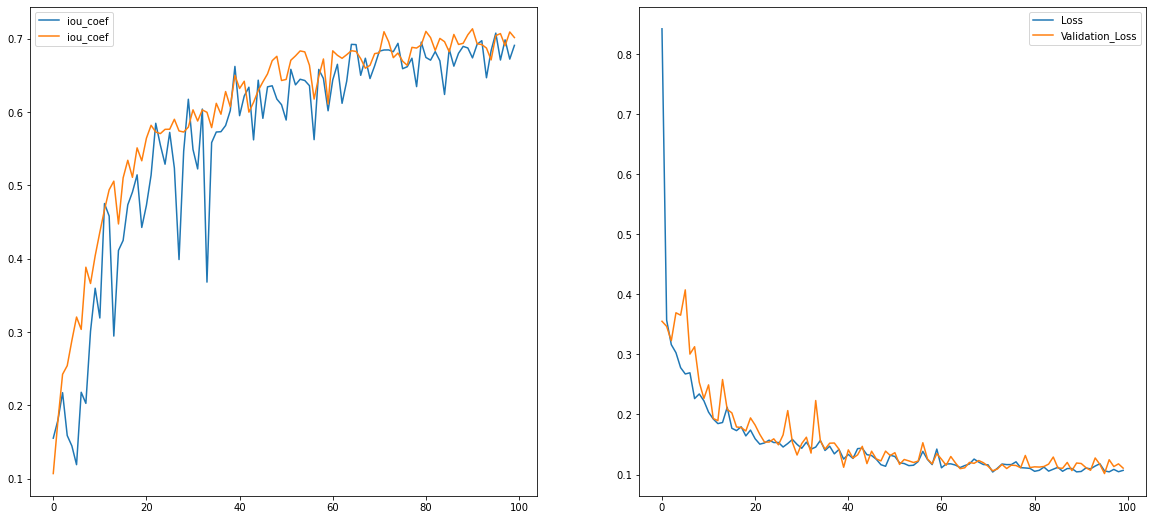

In [9]:
%%time
model_cnn4 = My_Model_((256,512,3)).build_model()
my_training_batch_generator = MY_Generator(df.id[:100], 4, canal=3, red_shape=(512, 256),
                                           augmented=True, shufle=True)
my_validation_batch_generator = MY_Generator(df.id[100:140], 4, canal=3, red_shape=(512, 256), 
                                             augmented=True)

model_cnn4.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[iou_coef])
model_history4 = model_cnn4.fit_generator(generator=my_training_batch_generator,
                    validation_data=my_validation_batch_generator,
                    epochs=100,
                    verbose=1,
                    workers=2,
                    callbacks = callback
                    )

plt_learningcurve(model_history4, 'iou_coef')

<timed exec>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


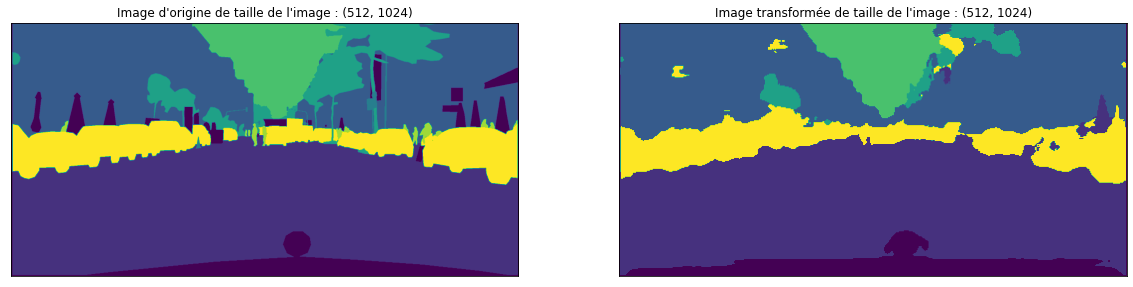

In [15]:
show_2img(y_true[4],model_cnn4.predict_class(np.array([resize(X[4], (512, 256))]), (512, 256))[0])

# Evaluation des modèles